In [1]:
from nilearn.image import load_img, new_img_like
from nilearn import plotting
from nilearn.input_data import NiftiMasker
from sklearn.feature_extraction.image import grid_to_graph
import numpy as np
import time
from sklearn.cluster import AgglomerativeClustering
import os
import matplotlib.pyplot as plt


In [2]:
sub_name = "NYU_0051091"
raw_img = load_img("{}_func_minimal.nii.gz".format(sub_name), 1)
print(raw_img.shape)
connectivity  = grid_to_graph(*raw_img.shape[:3])
print(connectivity.shape)

(61, 73, 61, 176)
(271633, 271633)


In [3]:
flat_img = (raw_img.get_fdata()).reshape(-1,176)
flat_img.shape

(271633, 176)

(176, 61501)


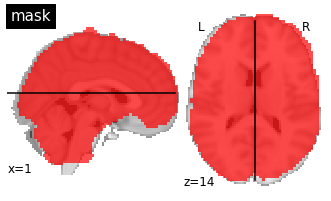

In [8]:
nifti_masker = NiftiMasker(mask_strategy='epi')
nifti_masker.fit(raw_img)
flat_img = nifti_masker.transform(raw_img)
print(flat_img.shape) 

mask_img = nifti_masker.mask_img_
plotting.plot_roi(mask_img,title="mask",
                  display_mode='xz',cmap="prism")

In [27]:
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 200  # number of regions
ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
                               connectivity=connectivity)
ward.fit(flat_img)
labels = np.reshape(ward.labels_, raw_img.shape[0:3])
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", labels.size)
print("Number of clusters: ", np.unique(labels).size)

Compute structured hierarchical clustering...


ValueError: Wrong shape for connectivity matrix: (271633, 271633) when X is (176, 61501)

In [5]:
out_dir = "{}".format(sub_name)

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
clustered_img = new_img_like(os.path.join(out_dir, "rena_parcellation.nii.gz"),labels)
clustered_img.to_filename(os.path.join(out_dir, "skward_parcellation.nii.gz"))

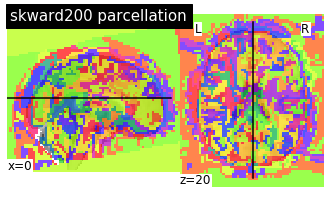

In [11]:
img = plotting.plot_roi("NYU_0051091/skward_parcellation.nii.gz",title="skward200 parcellation",
                  display_mode='xz',cmap="prism")

(61, 73, 61)


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


<function matplotlib.pyplot.show(*args, **kw)>

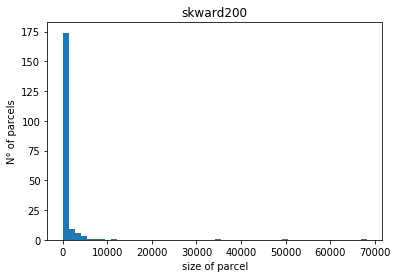

In [7]:
# Histogramme
parcelated_img = load_img("NYU_0051091/skward_parcellation.nii.gz", 1)
print(parcelated_img.shape)
data = parcelated_img.get_data()[np.nonzero(parcelated_img.get_data())]
unique, counts = np.unique(data, return_counts=True)

plt.hist(counts,bins=50)
plt.title("skward200")
plt.xlabel('size of parcel')
plt.ylabel('N° of parcels')
plt.show

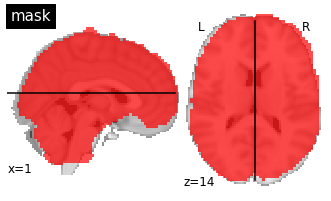

In [24]:
masked_clusters = nifti_masker.transform(clustered_img)
plotting.plot_roi(masked_clusters,title="masked skward200 parcellation",
                  display_mode='xz',cmap="prism")

TypeError: Data given cannot be loaded because it is not compatible with nibabel format:
58.233213715713866

In [23]:
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 200  # number of regions
ward_no_conectivity = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
ward_no_conectivity.fit(flat_img)
label_no_conectivity = np.reshape(ward_no_conectivity.labels_, raw_img.shape[0:3])
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", label_no_conectivity.size)
print("Number of clusters: ", np.unique(label_no_conectivity).size)

Compute structured hierarchical clustering...


MemoryError: Unable to allocate 275. GiB for an array with shape (36892107528,) and data type float64

In [ ]:
# Plot the results on an image
plt.figure(figsize=(5, 5))
plt.imshow(rescaled_coins, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(label == l,
                colors=[plt.cm.nipy_spectral(l / float(n_clusters)), ])
plt.xticks(())
plt.yticks(())
plt.show()